In [7]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#80A6E2", "#FBDD85", "#F46F43", "#CF3D3E"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
# cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"E:\MS_ExperimentData\general"
MP4_PATH = r"E:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

In [8]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    dt=0.001,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=9, overWrite=True
)

In [11]:
model.run(20000)

  0%|          | 0/20000 [00:00<?, ?it/s]

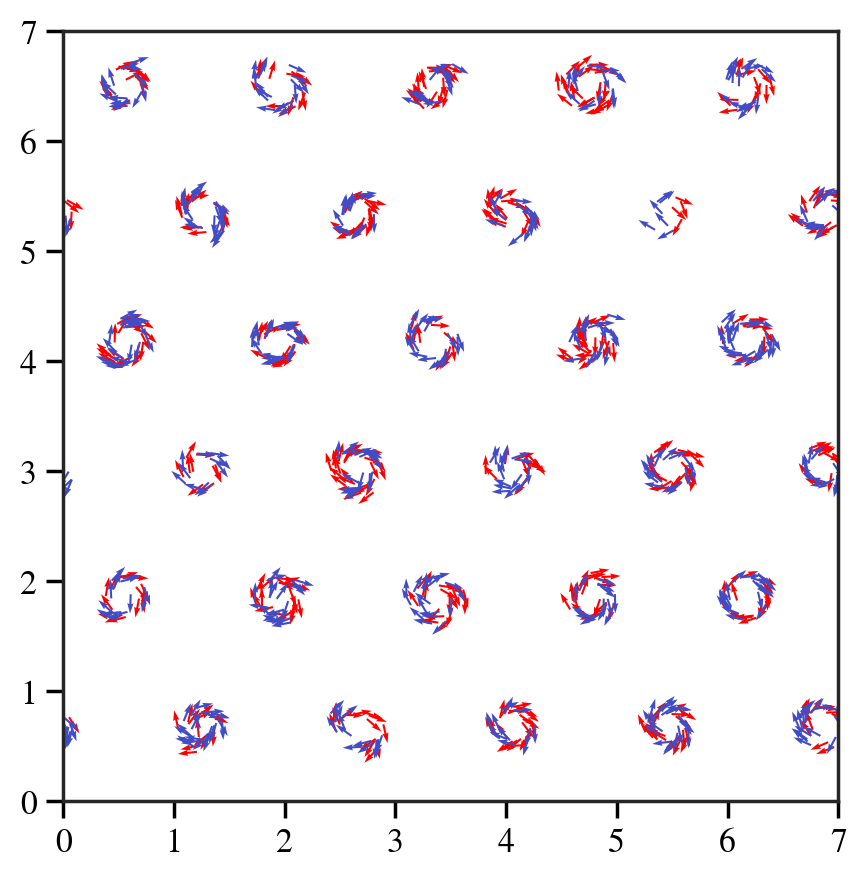

In [12]:
# 80000
model.plot()

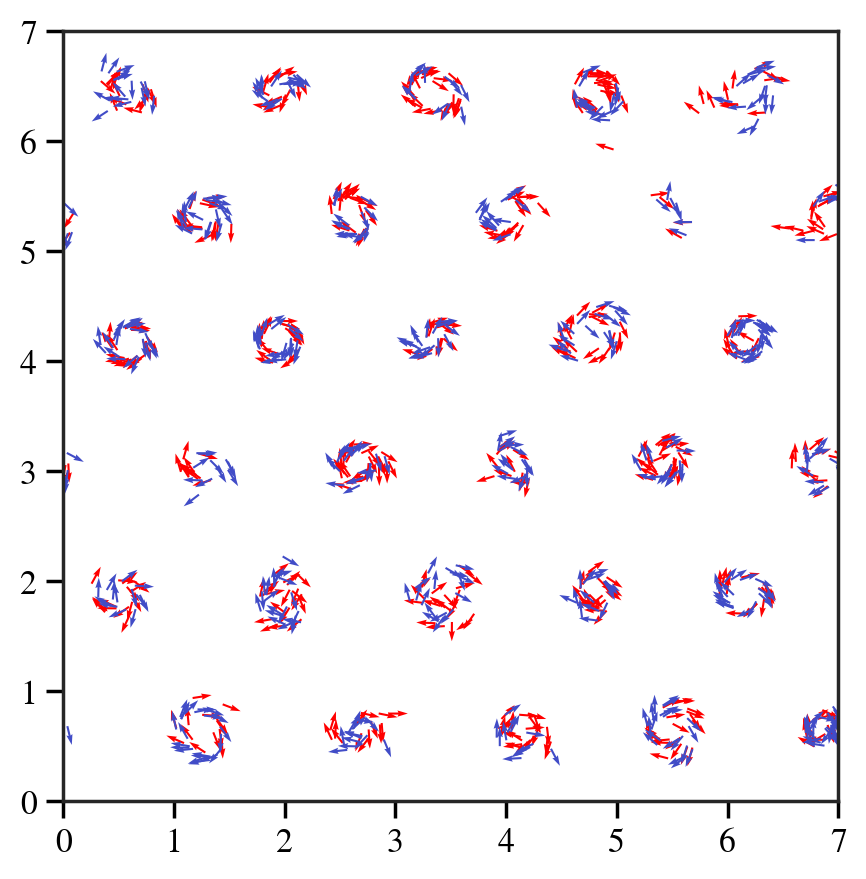

In [ ]:
# 60000
model.plot()

In [3]:
sa = StateAnalysis(model)

In [4]:
classes, centers = sa.calc_classes_and_centers(classDistance=0.5, lookIdx=-1)
tailDotPhaseThetas = np.array([sa.calc_dot_theta(lookIdx=i) for i in np.arange(-100, 0)])
effectiveFreqs = tailDotPhaseThetas.mean(axis=0)

classCenters = np.array([centers[c].mean(axis=0) for c in classes])
edges, ajdClassCenters = sa.calc_nearby_edges(edgeLenThres=1.5, classCenters=classCenters)

classPosPerent = list()
classNegPerent = list()
classMeanPosFreq = list()
classMeanNegFreq = list()
classMeanFreq = list()
classMeanEffFreq = list()

for classIdx, oscIdx in enumerate(classes):
    freqOmega: np.ndarray = sa.model.freqOmega[oscIdx]

    posPerent = (freqOmega >= 0).mean()
    negPerent = (freqOmega < 0).mean()
    
    meanPosFreq = freqOmega[freqOmega >= 0].mean()
    meanNegFreq = freqOmega[freqOmega < 0].mean()

    meanFreq = freqOmega.mean()
    meanEffFreq = effectiveFreqs[oscIdx].mean()
    
    classPosPerent.append(posPerent)
    classNegPerent.append(negPerent)
    classMeanPosFreq.append(meanPosFreq)
    classMeanNegFreq.append(meanNegFreq)
    classMeanFreq.append(meanFreq)
    classMeanEffFreq.append(meanEffFreq)

classPosPerent = np.array(classPosPerent)
classNegPerent = np.array(classNegPerent)
classMeanPosFreq = np.array(classMeanPosFreq)
classMeanNegFreq = np.array(classMeanNegFreq)

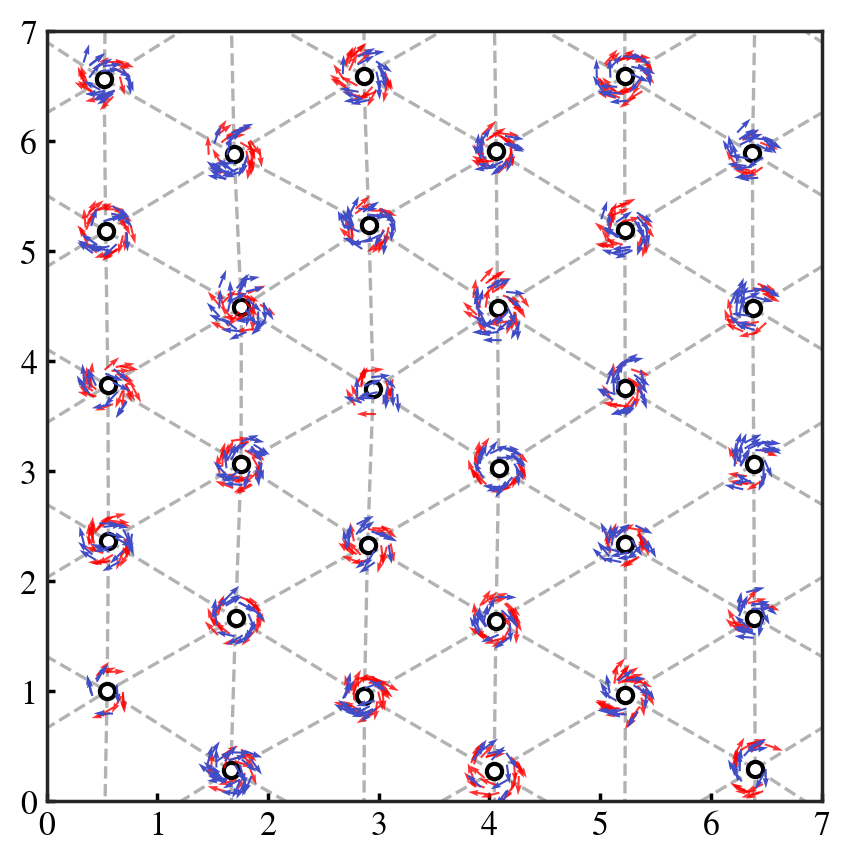

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(
    classCenters[:, 0], classCenters[:, 1], 
    facecolor="white", cmap=cmap, s=30, edgecolor="black", lw=1.5
)

for edge in edges[:]:
    plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1], 
             color="black", lw=1.2, alpha=0.3, linestyle="--", zorder=0)

sa.plot_spatial(ax=ax)

xShift = 0.5
plt.xlim(0 + xShift, sa.model.boundaryLength + xShift)
plt.ylim(0, sa.model.boundaryLength)
plt.xticks(
    np.arange(0 + xShift, sa.model.boundaryLength + xShift + 1),
    np.arange(0, sa.model.boundaryLength + 1))
plt.tick_params(length=3, direction="in")

# plt.savefig(f"{LOCAL_FIG_PATH}/snapshot.pdf", bbox_inches="tight")

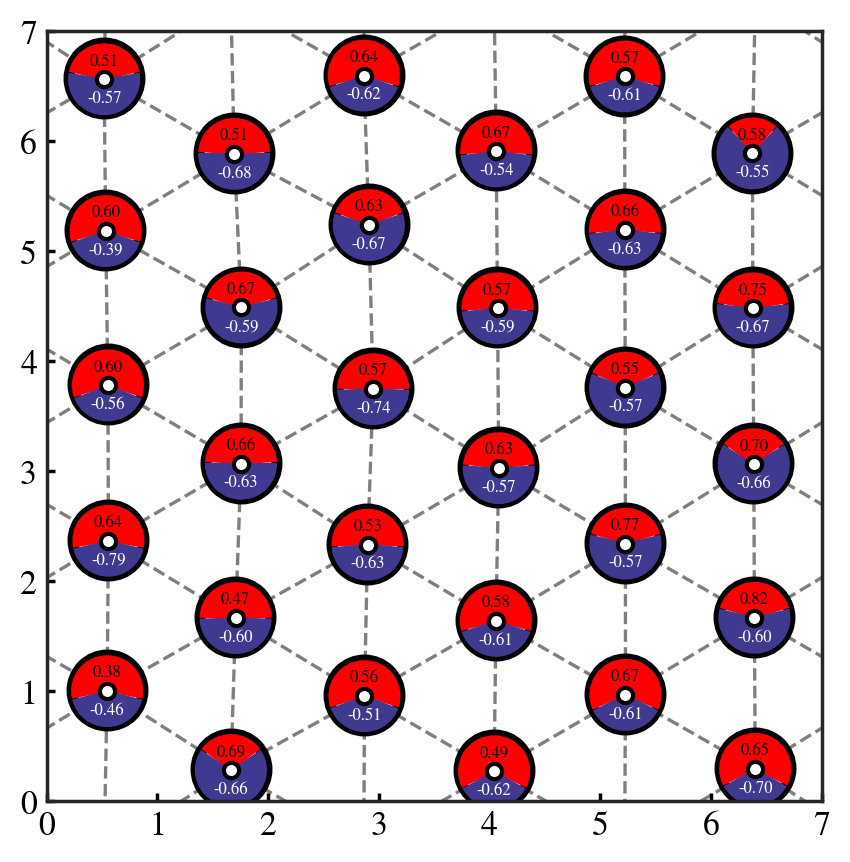

In [21]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(
    classCenters[:, 0] - 0.003, classCenters[:, 1] + 0.008, 
    facecolor="white", cmap=cmap, s=650, edgecolor="black", lw=4
)
plt.scatter(
    classCenters[:, 0], classCenters[:, 1], 
    facecolor="white", cmap=cmap, s=30, edgecolor="black", lw=1.5, zorder=10
)

for edge in edges[:]:
    plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1], 
             color="black", lw=1.2, alpha=0.5, linestyle="--", zorder=0)

width = 0.4
height = 0.4
linewidth = 10
textLength = 0.17
posTextAngle = np.pi * 0.5
negTextAngle = np.pi * 1.5

for classIdx in range(len(classes)):
    posPerent = classPosPerent[classIdx]
    negPerent = classNegPerent[classIdx]
    meanPosFreq = classMeanPosFreq[classIdx]
    meanNegFreq = classMeanNegFreq[classIdx]
    classCenter = classCenters[classIdx]
    angle = 90 - 360 * posPerent / 2
    ax.add_patch(patches.Arc(xy=classCenter, width=width, height=height,  
                             theta1=angle, theta2=angle + 360 * posPerent, 
                            #  color=cmap((meanPosFreq - min(classMeanPosFreq)) / (max(classMeanPosFreq) - min(classMeanPosFreq)) / 2 + 0.5), 
                             color="red",
                             alpha=1, lw=linewidth))
    ax.add_patch(patches.Arc(xy=classCenter, width=width, height=height, 
                             theta1=angle + 360 * posPerent, theta2=angle + 360, 
                            #  color=cmap((meanNegFreq - min(classMeanNegFreq)) / (max(classMeanNegFreq) - min(classMeanNegFreq)) / 2), 
                             color="#403990",
                             alpha=1, lw=linewidth))
    ax.text(classCenter[0] + textLength * np.cos(posTextAngle),
            classCenter[1] + textLength * np.sin(posTextAngle),
            f"{meanPosFreq:.2f}", ha="center", va="center", fontsize=6, color="black")
    ax.text(classCenter[0] + textLength * np.cos(negTextAngle),
            classCenter[1] + textLength * np.sin(negTextAngle),
            f"{meanNegFreq:.2f}", ha="center", va="center", fontsize=6, color="white")

xShift = 0.5
plt.xlim(0 + xShift, sa.model.boundaryLength + xShift)
plt.ylim(0, sa.model.boundaryLength)
plt.xticks(
    np.arange(0 + xShift, sa.model.boundaryLength + xShift + 1),
    np.arange(0, sa.model.boundaryLength + 1))
plt.tick_params(length=3, direction="in")

plt.savefig(f"{LOCAL_FIG_PATH}/statistics.pdf", bbox_inches="tight")

In [23]:
edgeLenThres = 1.5

nearbyMeanFreqs = dict()

for i in range(len(classes)):
    selectClassFreq = classMeanFreq[i]
    nearbyMeanFreqs[selectClassFreq] = list()
    relativeDistance = sa.calc_replative_distance(classCenters[i], classCenters)
    nearbyClassIdx = np.where(
        (relativeDistance < edgeLenThres) & (relativeDistance > 0.1)
    )[0]
    for j in nearbyClassIdx:
        nearbyMeanFreqs[selectClassFreq].append(classMeanFreq[j])

xFreqs = list()
yFreqs = list()

for k, v in nearbyMeanFreqs.items():
    xFreqs += [k] * len(v)
    yFreqs += v

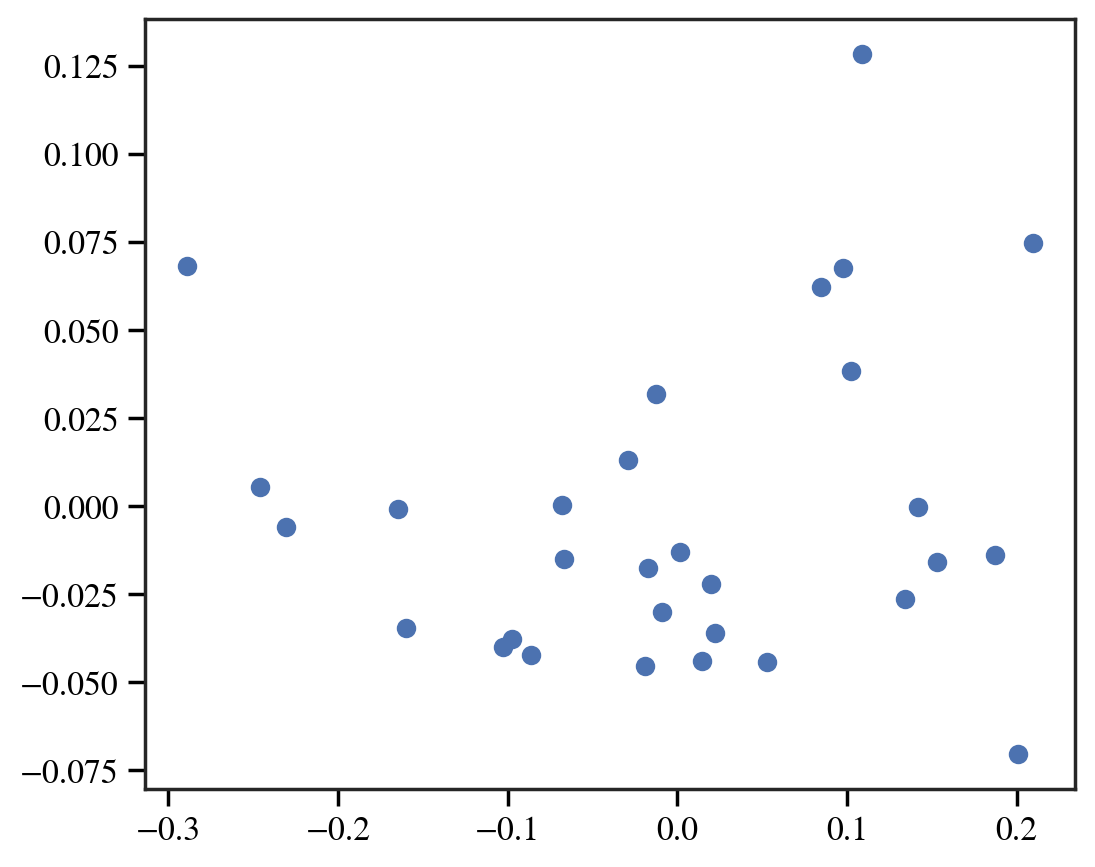

In [24]:
meanNearByFreq = [np.mean(v) for v in nearbyMeanFreqs.values()]
plt.scatter(nearbyMeanFreqs.keys(), meanNearByFreq)

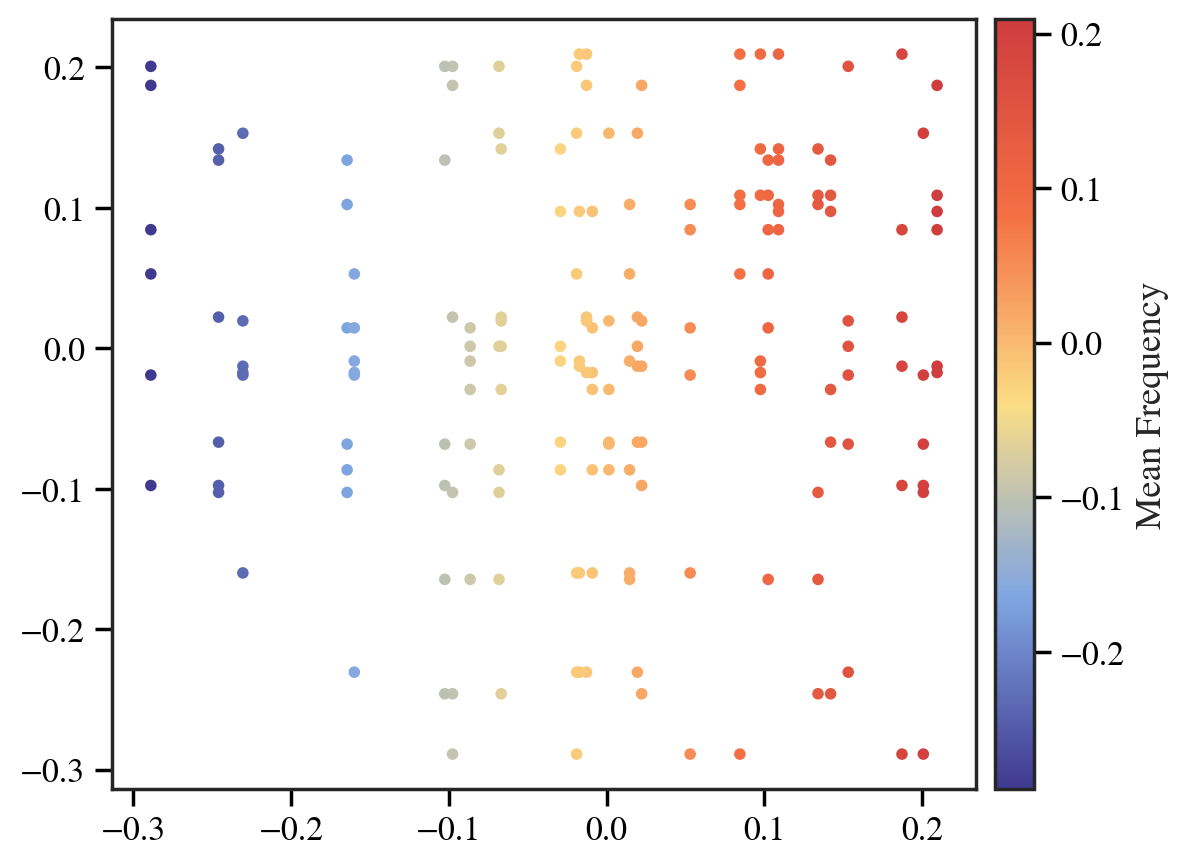

In [25]:
sc = plt.scatter(xFreqs, yFreqs, s=10, c=xFreqs, cmap=cmap)
plt.colorbar(sc, label="Mean Frequency", fraction=0.05, pad=0.02)

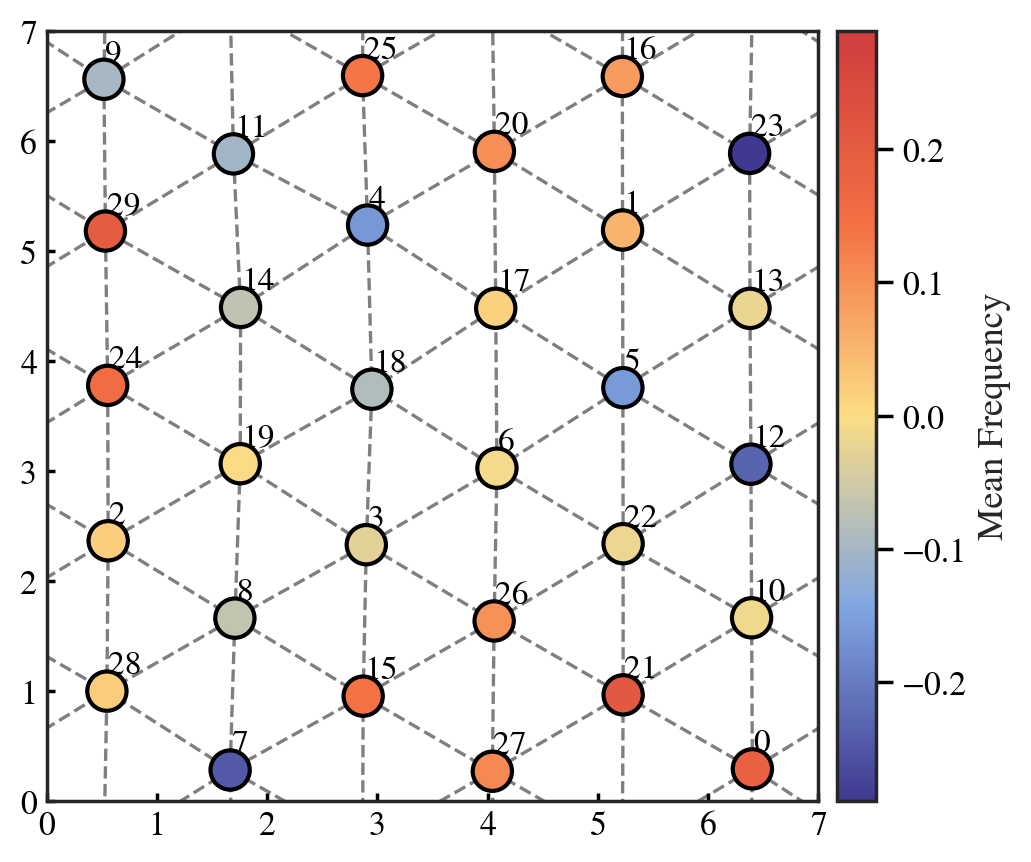

In [33]:
fig, ax = plt.subplots(figsize=(6, 5))

bound = np.abs(classMeanFreq).max()

sc = plt.scatter(
    classCenters[:, 0], classCenters[:, 1], 
    c=classMeanFreq, s=200, edgecolor="black", lw=1.5, zorder=10,
    cmap=cmap, vmin=-bound, vmax=bound
)
plt.colorbar(sc, label="Mean Frequency", orientation="vertical", pad=0.02)

for edge in edges[:]:
    plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1], 
             color="black", lw=1.2, alpha=0.5, linestyle="--", zorder=0)
    
for i, classCenter in enumerate(classCenters):
    plt.text(
        classCenter[0] + 0.01, classCenter[1] + 0.1, 
        f"{i}", ha="left", va="bottom", fontsize=12, color="black"
    )

xShift = 0.5
plt.xlim(0 + xShift, sa.model.boundaryLength + xShift)
plt.ylim(0, sa.model.boundaryLength)
plt.xticks(
    np.arange(0 + xShift, sa.model.boundaryLength + xShift + 1),
    np.arange(0, sa.model.boundaryLength + 1))
plt.tick_params(length=3, direction="in")
plt.savefig(f"{LOCAL_FIG_PATH}/mean_freq.pdf", bbox_inches="tight")

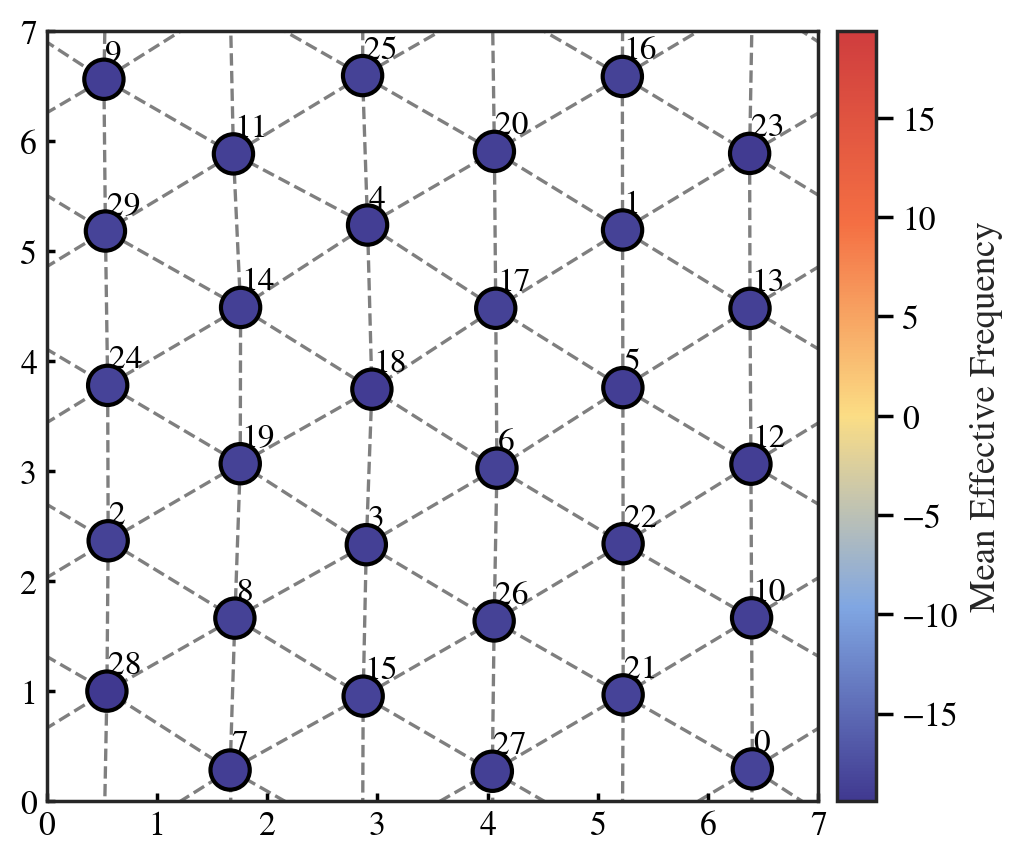

In [34]:
fig, ax = plt.subplots(figsize=(6, 5))

bounds = np.abs(classMeanEffFreq).max()

sc = plt.scatter(
    classCenters[:, 0], classCenters[:, 1], 
    c=classMeanEffFreq, s=200, edgecolor="black", lw=1.5, zorder=10,
    cmap=cmap, vmin=-bounds, vmax=bounds
)
# sc = plt.scatter(-np.ones(len(classes)*2), -np.ones(len(classes)*2), cmap=cmap,
#                  c=np.concatenate([classMeanEffFreq, -np.array(classMeanEffFreq)]))
plt.colorbar(sc, label="Mean Effective Frequency", orientation="vertical", pad=0.02)

for edge in edges[:]:
    plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1], 
             color="black", lw=1.2, alpha=0.5, linestyle="--", zorder=0)
    
for i, classCenter in enumerate(classCenters):
    plt.text(
        classCenter[0] + 0.01, classCenter[1] + 0.1, 
        f"{i}", ha="left", va="bottom", fontsize=12, color="black"
    )

xShift = 0.5
plt.xlim(0 + xShift, sa.model.boundaryLength + xShift)
plt.ylim(0, sa.model.boundaryLength)
plt.xticks(
    np.arange(0 + xShift, sa.model.boundaryLength + xShift + 1),
    np.arange(0, sa.model.boundaryLength + 1))
plt.tick_params(length=3, direction="in")
plt.savefig(f"{LOCAL_FIG_PATH}/mean_eff_freq.pdf", bbox_inches="tight")

In [27]:
edgeLenThres = 1.5

highPosClassIdx = np.arange(len(classes))[classPosPerent > 0.6]
nearbyPosPerent = list()
nearbyNegPerent = list()

for classIdx in highPosClassIdx:
    relativeDistance = sa.calc_replative_distance(
        position1=classCenters[classIdx], position2=classCenters
    )
    nearbyClassIdx = np.where(
        (relativeDistance < edgeLenThres) & (relativeDistance > 0.1)
    )[0]
    nearbyNegPerent += classNegPerent[nearbyClassIdx].tolist()
    nearbyPosPerent += classPosPerent[nearbyClassIdx].tolist()

print("Nearby positive parent percentage:", np.mean(nearbyPosPerent))
print("Nearby negative parent percentage:", np.mean(nearbyNegPerent))

highNegClassIdx = np.arange(len(classes))[classNegPerent > 0.6]
nearbyPosPerent = list()
nearbyNegPerent = list()

for classIdx in highNegClassIdx:
    relativeDistance = sa.calc_replative_distance(
        position1=classCenters[classIdx], position2=classCenters
    )
    nearbyClassIdx = np.where(
        (relativeDistance < edgeLenThres) & (relativeDistance > 0.1)
    )[0]
    nearbyNegPerent += classNegPerent[nearbyClassIdx].tolist()
    nearbyPosPerent += classPosPerent[nearbyClassIdx].tolist()

print("Nearby positive parent percentage:", np.mean(nearbyPosPerent))
print("Nearby negative parent percentage:", np.mean(nearbyNegPerent))

Nearby positive parent percentage: 0.5261942751860011
Nearby negative parent percentage: 0.4738057248139988
Nearby positive parent percentage: 0.5022634880701256
Nearby negative parent percentage: 0.4977365119298745
